## Meta-Learning with the Rank-Weighted GP Ensemble (RGPE)

BoTorch is designed in to be model-agnostic and only requries that a model conform to a minimal interface. This tutorial walks through an example of implementing the rank-weighted Gaussian process ensemble (RGPE) [Feurer, Letham, Bakshy ICML 2018 AutoML Workshop] and using the RGPE in BoTorch to do meta-learning across related optimization tasks.

* Original paper: https://arxiv.org/pdf/1802.02219.pdf

In [1]:
import os
import torch
import math


torch.manual_seed(29)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [15]:
# import torch
# from botorch.acquisition.acquisition import AcquisitionFunction
# from botorch.acquisition.analytic import ExpectedImprovement
# from botorch.models.gpytorch import GPyTorchModel

# class TransferAcquisitionFunction(AcquisitionFunction):
#     def __init__(self, model: GPyTorchModel, base_models: list, weights: torch.Tensor, best_f: torch.Tensor):
#         """
#         Initialize the Transfer Acquisition Function.
        
#         model: The current GP model trained on the target task.
#         base_models: List of GP models trained on previous tasks.
#         weights: Tensor of weights indicating the relevance of each base model to the current task.
#         best_f: The best value observed so far.
#         """
#         super().__init__(model)
#         self.model = model
#         self.base_models = base_models
#         self.weights = weights
#         self.ei = ExpectedImprovement(model=model, best_f=best_f)

#     def forward(self, X):
#         # Compute the EI for the target model
#         ei = self.ei(X)

#         # If the current task has full weight (i.e., no transfer), return EI directly
#         if self.weights[-1] == 1:
#             return ei

#         # Compute improvements from base models
#         improvements = []
#         for weight, base_model in zip(self.weights[:-1], self.base_models):
#             if weight == 0:
#                 continue
#             with torch.no_grad():
#                 pred = base_model.posterior(X).mean
#                 best_value = pred.max()  # Change to min() for minimization
#                 improvement = torch.clamp(pred - best_value, min=0) * weight  # Reverse subtraction for minimization
#                 improvements.append(improvement)

#         # Sum the improvements
#         if improvements:
#             improvements_sum = torch.sum(torch.stack(improvements), dim=0)
#         else:
#             improvements_sum = torch.zeros_like(ei)

#         # Combine EI with improvements
#         return ei * self.weights[-1] + improvements_sum

import torch
from botorch.acquisition.acquisition import AcquisitionFunction
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.models.gpytorch import GPyTorchModel

class TransferAcquisitionFunction(AcquisitionFunction):
    def __init__(self, model: GPyTorchModel, base_models: list, weights: torch.Tensor, best_f: torch.Tensor):
        super().__init__(model)
        self.model = model
        self.base_models = base_models
        self.weights = weights
        self.ei = ExpectedImprovement(model=model, best_f=best_f)

    def forward(self, X):
        # Compute the EI for the target model
        ei = self.ei(X)
        
        # Debug: Print EI values to ensure they are not flat
        print(f"EI values: {ei}")

        # If the current task has full weight (i.e., no transfer), return EI directly
        if self.weights[-1] == 1:
            return ei

        # Compute improvements from base models
        improvements = []
        for weight, base_model in zip(self.weights[:-1], self.base_models):
            if weight == 0:
                continue
            with torch.no_grad():
                pred = base_model.posterior(X).mean
                best_value = pred.max()  # Change to min() for minimization
                
                # Debug: Print prediction and best_value to understand their range
                print(f"Prediction: {pred}, Best Value: {best_value}")
                
                improvement = torch.clamp(pred - best_value, min=0) * weight  # Reverse subtraction for minimization
                improvements.append(improvement)

        # Sum the improvements
        if improvements:
            improvements_sum = torch.sum(torch.stack(improvements), dim=0)
        else:
            improvements_sum = torch.zeros_like(ei)

        # Debug: Print the improvements sum
        print(f"Improvements Sum: {improvements_sum}")

        # Combine EI with improvements
        return ei * self.weights[-1] + improvements_sum


### Toy Problem
* We consider optimizing the following 1-D synthetic function
$$f(x, s_i) = \frac{1}{10}\bigg(x-1\bigg)\bigg(\sin(x+s_i)+\frac{1}{10}\bigg)$$
where
$$s_i = \frac{(i+9)\pi}{8}$$
is a task-dependent shift parameter and $i$ is the task index $i \in [1, t]$.

* In this tutorial, we will consider the scenario where we have collected data from 5 prior tasks (referred to as base tasks), which with a different task dependent shift parameter $s_i$.

* The goal now is use meta-learning to improve sample efficiency when optimizing a 6th task.

#### Toy Problem Setup

First let's define a function for compute the shift parameter $s_i$ and set the shift amount for the target task.

In [3]:
NUM_BASE_TASKS = 5 if not SMOKE_TEST else 2
# NUM_BASE_TASKS = 4 if not SMOKE_TEST else 2 # for Schaffer

def task_shift(task):
    """
    Fetch shift amount for task.
    """
    return math.pi * task / 12.0

# Set shift for base tasks (for Schaffer and other functions)
shift_values = [1.2, 1.4, 1.6, 1.8]    ### Shift values


# set shift for target task

TARGET_SHIFT = 0.0 # (for default Alpine function)
# TARGET_SHIFT = 1.0 # (for Schaffer)

Then, let's define our function $f(x, s_i)$ and set bounds on $x$.

In [4]:
BOUNDS = torch.tensor([[-10], [10.0]], dtype=dtype, device=device) # For default Alpine function
# BOUNDS = torch.tensor([[0], [2.0]], dtype=dtype, device=device) # For Schaffer

def f(X, shift=TARGET_SHIFT):
    """
    Torch-compatible objective function for the target_task
    """
    f_X = X * torch.sin(X + math.pi + shift) + X / 10.0
    
    # Schaffer
    # f_X = -(shift*X-2)**2
    
    return f_X

In [49]:
# import numpy as np
# x = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 100).unsqueeze(-1)
# y=f(x,1)
# torch.std(y)

#### Sample training data for prior base tasks

We sample data from a Sobol sequence to help ensure numerical stability when using a small amount of 1-D data. Sobol sequences help prevent us from sampling a bunch of training points that are close together.

In [5]:
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import normalize, unnormalize


noise_std = 0.05

# Sample data for each base task
data_by_task = {}
for task in range(NUM_BASE_TASKS):
    num_training_points = 20
    # draw points from a sobol sequence
    raw_x = draw_sobol_samples(
        bounds=BOUNDS,
        n=num_training_points,
        q=1,
        seed=task + 5397923,
    ).squeeze(1)
    # get observed values
    f_x = f(raw_x, task_shift(task + 1))
    train_y = f_x + noise_std * torch.randn_like(f_x)
    train_yvar = torch.full_like(train_y, noise_std**2)
    # store training data
    data_by_task[task] = {
        # scale x to [0, 1]
        "train_x": normalize(raw_x, bounds=BOUNDS),
        "train_y": train_y,
        "train_yvar": train_yvar,
    }


# # For Schaffer & other benchmarking functions
# noise_std = 0.05

# # Sample data for each base task
# data_by_task = {}
# for task in range(NUM_BASE_TASKS):
#     num_training_points = 20
#     # draw points from a sobol sequence
#     raw_x = draw_sobol_samples(
#         bounds=BOUNDS,
#         n=num_training_points,
#         q=1,
#         seed=task + 5397923,
#     ).squeeze(1)
#     # get observed values
#     f_x = f(raw_x, shift_values[task])
#     train_y = f_x + noise_std * torch.randn_like(f_x)
#     train_yvar = torch.full_like(train_y, noise_std**2)
#     # store training data
#     data_by_task[task] = {
#         # scale x to [0, 1]
#         "train_x": normalize(raw_x, bounds=BOUNDS),
#         "train_y": train_y,
#         "train_yvar": train_yvar,
#     }

#### Let's plot the base tasks and the target task function along with the observed points

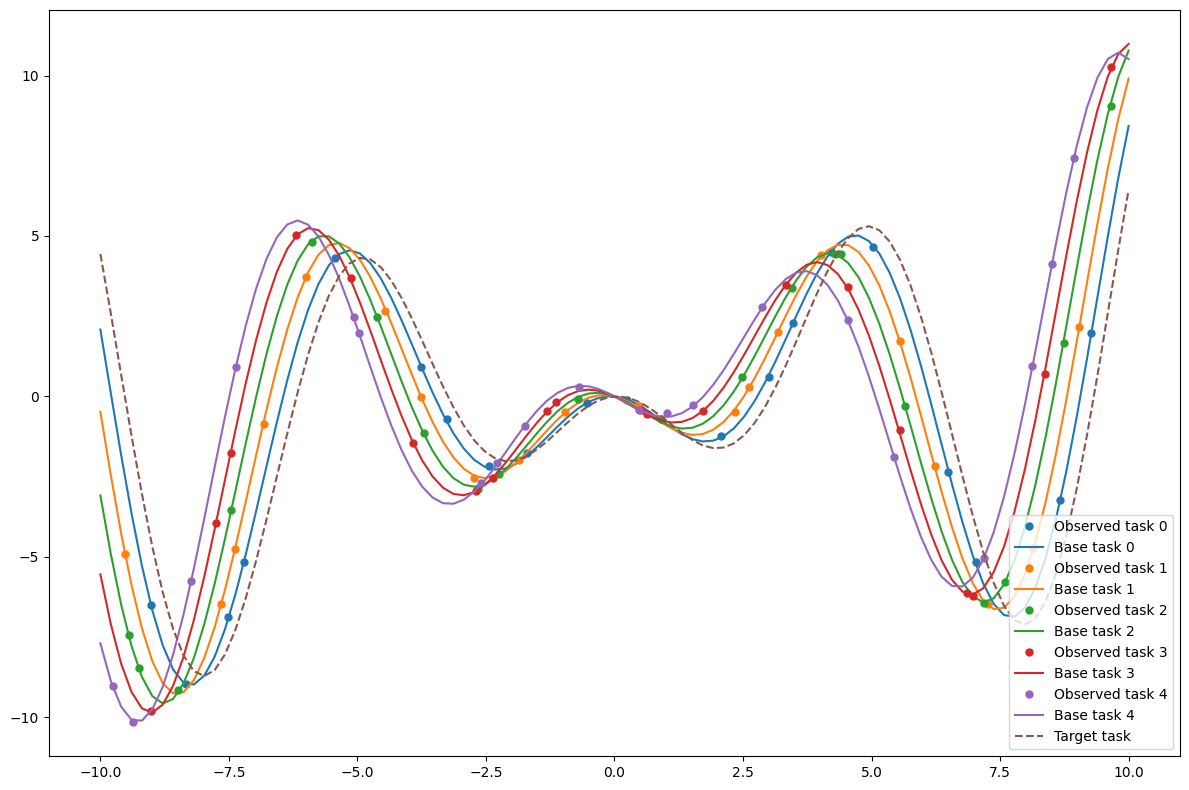

In [6]:
from matplotlib import pyplot as plt

# %matplotlib inline


fig, ax = plt.subplots(1, 1, figsize=(12, 8))
x = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 100).unsqueeze(-1)
for task in data_by_task:
    # plot true function and observed values for base runs
    t = ax.plot(
        unnormalize(data_by_task[task]["train_x"], bounds=BOUNDS).cpu().numpy(),
        data_by_task[task]["train_y"].cpu().numpy(),
        ".",
        markersize=10,
        label=f"Observed task {task}",
    )
    ax.plot(
        x.detach().numpy(),
        f(x, task_shift(task + 1)).cpu().numpy(),
        label=f"Base task {task}",
        color=t[0].get_color(),
    )
# plot true target function
ax.plot(
    x.detach().numpy(),
    f(x, TARGET_SHIFT).detach().numpy(),
    "--",
    label="Target task",
)
ax.legend(loc="lower right", fontsize=10)
plt.tight_layout()


# # Schaffer
# # Plotting

# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# x = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 100).unsqueeze(-1)

# for task in data_by_task:
#     # plot true function and observed values for base runs
#     t = ax.plot(
#         unnormalize(data_by_task[task]["train_x"], bounds=BOUNDS).cpu().numpy(),
#         data_by_task[task]["train_y"].cpu().numpy(),
#         ".",
#         markersize=10,
#         label=f"Observed task {task}",
#     )
#     ax.plot(
#         x.detach().numpy(),
#         f(x, shift_values[task]).cpu().numpy(),
#         label=f"Base task {task}",
#         color=t[0].get_color(),
#     )
# # plot true target function
# ax.plot(
#     x.detach().numpy(),
#     f(x, TARGET_SHIFT).detach().numpy(),
#     "--",
#     label="Target task",
# )
# ax.legend(loc="lower right", fontsize=10)
# plt.tight_layout()
# plt.show()

In [24]:
x

range(3, 14)

### Fit base task models

First, let's define a helper function to fit a FixedNoiseGP with an fixed observed noise level.

In [7]:
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import FixedNoiseGP
from botorch.fit import fit_gpytorch_mll


def get_fitted_model(train_X, train_Y, train_Yvar, state_dict=None):
    """
    Get a single task GP. The model will be fit unless a state_dict with model
        hyperparameters is provided.
    """
    Y_mean = train_Y.mean(dim=-2, keepdim=True)
    Y_std = train_Y.std(dim=-2, keepdim=True)
    model = FixedNoiseGP(train_X, (train_Y - Y_mean) / Y_std, train_Yvar)
    model.Y_mean = Y_mean
    model.Y_std = Y_std
    if state_dict is None:
        mll = ExactMarginalLogLikelihood(model.likelihood, model).to(train_X)
        fit_gpytorch_mll(mll)
    else:
        model.load_state_dict(state_dict)
    return model

#### Now let's fit a FixedNoiseGP for each base task

In [8]:
# Fit base model
base_model_list = []
for task in range(NUM_BASE_TASKS):
    print(f"Fitting base model {task}")
    model = get_fitted_model(
        data_by_task[task]["train_x"],
        data_by_task[task]["train_y"],
        data_by_task[task]["train_yvar"],
    )
    base_model_list.append(model)

Fitting base model 0
Fitting base model 1
Fitting base model 2
Fitting base model 3
Fitting base model 4


### Implement the RGPE

The main idea of the RGPE is to estimate the target function as weighted sum of the target model and the base models:
$$\bar f(\mathbf x | \mathcal D) =
\sum_{i=1}^{t} w_if^i(\mathbf x |\mathcal D_i)$$
Importantly, the ensemble model is also a GP:
$$\bar f(\mathbf x | \mathcal D) \sim \mathcal N\bigg(\sum_{i=1}^{t} w_i\mu_i(\mathbf x), \sum_{i=1}^{t}w_i^2\sigma_i^2\bigg)$$

The weights $w_i$ for model $i$ are based on the the ranking loss between a draw from the model's posterior and the targets. Specifically, the ranking loss for model $i$ is:
$$\mathcal L(f^i, \mathcal D_t) = \sum_{j=1}^{n_t}\sum_{k=1}^{n_t}\mathbb 1\bigg[\bigg(f^i\big(\mathbf x^t_j\big) < f^i\big(\mathbf x_k^t\big)\bigg)\oplus \big(y_j^t < y_k^t\big)\bigg]$$
where $\oplus$ is exclusive-or.

The loss for the target model is computing using leave-one-out cross-validation (LOOCV) and is given by:
$$\mathcal L(f^t, \mathcal D_t) = \sum_{j=1}^{n_t}\sum_{k=1}^{n_t}\mathbb 1\bigg[\bigg(f^t_{-j}\big(\mathbf x^t_j\big) < f^t_{-j}\big(\mathbf x_k^t\big)\bigg)\oplus \big(y_j^t < y_k^t\big)\bigg]$$
where $f^t_{-j}$ model fitted to all data from the target task except training example $j$.

The weights are then computed as:
$$w_i = \frac{1}{S}\sum_{s=1}^S\mathbb 1\big(i = \text{argmin}_{i'}l_{i', s}\big)$$

In [9]:
def roll_col(X, shift):
    """
    Rotate columns to right by shift.
    """
    return torch.cat((X[..., -shift:], X[..., :-shift]), dim=-1)

In [10]:
def compute_ranking_loss(f_samps, target_y):
    """
    Compute ranking loss for each sample from the posterior over target points.

    Args:
        f_samps: `n_samples x (n) x n`-dim tensor of samples
        target_y: `n x 1`-dim tensor of targets
    Returns:
        Tensor: `n_samples`-dim tensor containing the ranking loss across each sample
    """
    n = target_y.shape[0]
    if f_samps.ndim == 3:
        # Compute ranking loss for target model
        # take cartesian product of target_y
        cartesian_y = torch.cartesian_prod(
            target_y.squeeze(-1),
            target_y.squeeze(-1),
        ).view(n, n, 2)
        # the diagonal of f_samps are the out-of-sample predictions
        # for each LOO model, compare the out of sample predictions to each in-sample prediction
        rank_loss = (
            (
                (f_samps.diagonal(dim1=1, dim2=2).unsqueeze(-1) < f_samps)
                ^ (cartesian_y[..., 0] < cartesian_y[..., 1])
            )
            .sum(dim=-1)
            .sum(dim=-1)
        )
    else:
        rank_loss = torch.zeros(
            f_samps.shape[0], dtype=torch.long, device=target_y.device
        )
        y_stack = target_y.squeeze(-1).expand(f_samps.shape)
        for i in range(1, target_y.shape[0]):
            rank_loss += (
                (roll_col(f_samps, i) < f_samps) ^ (roll_col(y_stack, i) < y_stack)
            ).sum(dim=-1)
    return rank_loss

Define a function to:
1. Create a batch mode-gp LOOCV GP using the hyperparameters from `target_model`
2. Draw a joint sample across all points from the target task (in-sample and out-of-sample)

In [11]:
def get_target_model_loocv_sample_preds(
    train_x, train_y, train_yvar, target_model, num_samples
):
    """
    Create a batch-mode LOOCV GP and draw a joint sample across all points from the target task.

    Args:
        train_x: `n x d` tensor of training points
        train_y: `n x 1` tensor of training targets
        target_model: fitted target model
        num_samples: number of mc samples to draw

    Return: `num_samples x n x n`-dim tensor of samples, where dim=1 represents the `n` LOO models,
        and dim=2 represents the `n` training points.
    """
    batch_size = len(train_x)
    masks = torch.eye(len(train_x), dtype=torch.uint8, device=device).bool()
    train_x_cv = torch.stack([train_x[~m] for m in masks])
    train_y_cv = torch.stack([train_y[~m] for m in masks])
    train_yvar_cv = torch.stack([train_yvar[~m] for m in masks])
    state_dict = target_model.state_dict()
    # expand to batch size of batch_mode LOOCV model
    state_dict_expanded = {
        name: t.expand(batch_size, *[-1 for _ in range(t.ndim)])
        for name, t in state_dict.items()
    }
    model = get_fitted_model(
        train_x_cv, train_y_cv, train_yvar_cv, state_dict=state_dict_expanded
    )
    with torch.no_grad():
        posterior = model.posterior(train_x)
        # Since we have a batch mode gp and model.posterior always returns an output dimension,
        # the output from `posterior.sample()` here `num_samples x n x n x 1`, so let's squeeze
        # the last dimension.
        sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_samples]))
        return sampler(posterior).squeeze(-1)

In [12]:
def compute_rank_weights(train_x, train_y, train_yvar, base_models, target_model, num_samples):
    """
    Compute ranking weights for each base model and the target model (using
        LOOCV for the target model). Note: This implementation does not currently
        address weight dilution, since we only have a small number of base models.

    Args:
        train_x: `n x d` tensor of training points (for target task)
        train_y: `n` tensor of training targets (for target task)
        base_models: list of base models
        target_model: target model
        num_samples: number of mc samples

    Returns:
        Tensor: `n_t`-dim tensor with the ranking weight for each model
    """
    ranking_losses = []
    # compute ranking loss for each base model
    for task in range(len(base_models)):
        model = base_models[task]
        # compute posterior over training points for target task
        posterior = model.posterior(train_x)
        sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_samples]))
        base_f_samps = sampler(posterior).squeeze(-1).squeeze(-1)
        # compute and save ranking loss
        ranking_losses.append(compute_ranking_loss(base_f_samps, train_y))
    # compute ranking loss for target model using LOOCV
    # f_samps
    target_f_samps = get_target_model_loocv_sample_preds(
        train_x,
        train_y,
        train_yvar,
        target_model,
        num_samples,
    )
    ranking_losses.append(compute_ranking_loss(target_f_samps, train_y))
    ranking_loss_tensor = torch.stack(ranking_losses)
    # compute best model (minimum ranking loss) for each sample
    best_models = torch.argmin(ranking_loss_tensor, dim=0)
    # compute proportion of samples for which each model is best
    rank_weights = (
        best_models.bincount(minlength=len(ranking_losses)).type_as(train_x)
        / num_samples
    )
    return rank_weights

In [13]:
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.models import GP
from gpytorch.distributions import MultivariateNormal
from gpytorch.lazy import PsdSumLazyTensor
from gpytorch.likelihoods import LikelihoodList
from torch.nn import ModuleList


class RGPE(GP, GPyTorchModel):
    """
    Rank-weighted GP ensemble. Note: this class inherits from GPyTorchModel which provides an
        interface for GPyTorch models in botorch.
    """

    _num_outputs = 1  # metadata for botorch

    def __init__(self, models, weights):
        super().__init__()
        self.models = ModuleList(models)
        for m in models:
            if not hasattr(m, "likelihood"):
                raise ValueError(
                    "RGPE currently only supports models that have a likelihood (e.g. ExactGPs)"
                )
        self.likelihood = LikelihoodList(*[m.likelihood for m in models])
        self.weights = weights
        self.to(weights)

    def forward(self, x):
        weighted_means = []
        weighted_covars = []
        # filter model with zero weights
        # weights on covariance matrices are weight**2
        non_zero_weight_indices = (self.weights**2 > 0).nonzero()
        non_zero_weights = self.weights[non_zero_weight_indices]
        # re-normalize
        non_zero_weights /= non_zero_weights.sum()

        for non_zero_weight_idx in range(non_zero_weight_indices.shape[0]):
            raw_idx = non_zero_weight_indices[non_zero_weight_idx].item()
            model = self.models[raw_idx]
            posterior = model.posterior(x)
            # unstandardize predictions 
            posterior_mean = posterior.mean.squeeze(-1) * model.Y_std + model.Y_mean
            posterior_cov = posterior.mvn.lazy_covariance_matrix * model.Y_std.pow(2)
            # apply weight
            weight = non_zero_weights[non_zero_weight_idx]
            weighted_means.append(weight * posterior_mean)
            weighted_covars.append(posterior_cov * weight**2)
        # set mean and covariance to be the rank-weighted sum the means and covariances of the
        # base models and target model
        mean_x = torch.stack(weighted_means).sum(dim=0)
        covar_x = PsdSumLazyTensor(*weighted_covars)
        return MultivariateNormal(mean_x, covar_x)

### Optimize target function using RGPE + qNEI

In [16]:
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.optim.optimize import optimize_acqf

# suppress GPyTorch warnings about adding jitter
import warnings


warnings.filterwarnings("ignore", "^.*jitter.*", category=RuntimeWarning)


best_rgpe_all = []
best_random_all = []
best_vanilla_nei_all = []
rank_weights_all = []
N_BATCH = 10 if not SMOKE_TEST else 2
NUM_POSTERIOR_SAMPLES = 256 if not SMOKE_TEST else 16
RANDOM_INITIALIZATION_SIZE = 3
N_TRIALS = 8 # if not SMOKE_TEST else 2
MC_SAMPLES = 512 if not SMOKE_TEST else 32
N_RESTART_CANDIDATES = 512 if not SMOKE_TEST else 8
N_RESTARTS = 10 if not SMOKE_TEST else 2
Q_BATCH_SIZE = 1


# Average over multiple trials
for trial in range(N_TRIALS):
    print(f"Trial {trial + 1} of {N_TRIALS}")
    best_rgpe = []
    best_random = []
    best_vanilla_nei = []
    rank_weights_list = []

    
    # Initial random observations
    raw_x = draw_sobol_samples(
        bounds=BOUNDS, n=RANDOM_INITIALIZATION_SIZE, q=1, seed=trial
    ).squeeze(1)
    train_x = normalize(raw_x, bounds=BOUNDS)
    
    train_y_noiseless = f(raw_x)
    train_y = train_y_noiseless + noise_std * torch.randn_like(train_y_noiseless)
    
    train_yvar = torch.full_like(train_y, noise_std**2)
    vanilla_nei_train_x = train_x.clone()
    vanilla_nei_train_y = train_y.clone()
    vanilla_nei_train_yvar = train_yvar.clone()
    # keep track of the best observed point at each iteration
    best_value = train_y.max().item()
    best_rgpe.append(best_value)
    best_random.append(best_value)
    vanilla_nei_best_value = best_value
    best_vanilla_nei.append(vanilla_nei_best_value)

    # Run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(N_BATCH):
        target_model = get_fitted_model(train_x, train_y, train_yvar)
        model_list = base_model_list + [target_model]
        rank_weights = compute_rank_weights(
            train_x,
            train_y,
            train_yvar,
            base_model_list,
            target_model,
            NUM_POSTERIOR_SAMPLES,
        )

        rank_weights_list.append(rank_weights)
        
        # create RGPE model 
        rgpe_model = RGPE(model_list, rank_weights)

        # # and acquisition function
        # sampler_qnei = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
        # qNEI = qNoisyExpectedImprovement(
        #     model=rgpe_model,
        #     X_baseline=train_x,
        #     sampler=sampler_qnei,
        #     prune_baseline=False,
        # )

        # Compute best_f as the maximum or minimum value observed so far
        best_f = train_y.max() # if maximize else train_y.min()

        # Initialize TAF acquisition function
        taf = TransferAcquisitionFunction(
            model=target_model,
            base_models=base_model_list,
            weights=rank_weights,
            best_f=best_f  # Pass the calculated best_f
        )

        # # Generate Sobol initial conditions
        # sobol_initial_conditions = draw_sobol_samples(
        #     bounds=torch.tensor([[0.0], [1.0]], dtype=dtype, device=device),
        #     n=N_RESTARTS,  # Number of starting points for optimization
        #     q=Q_BATCH_SIZE,
        #     seed=iteration + trial,  # Ensure different seeds for different iterations and trials
        # ).squeeze(1)

        # optimize
        # candidate, _ = optimize_acqf(
        #     acq_function=qNEI,
        #     bounds=torch.tensor([[0.0], [1.0]], dtype=dtype, device=device),
        #     q=Q_BATCH_SIZE,
        #     num_restarts=N_RESTARTS,
        #     raw_samples=N_RESTART_CANDIDATES,
        # )

        # Optimize with Sobol initial conditions
        candidate, _ = optimize_acqf(
            acq_function=taf,  # Use TAF instead of qNEI
            bounds=torch.tensor([[0.0], [1.0]], dtype=dtype, device=device),
            q=Q_BATCH_SIZE,
            num_restarts=N_RESTARTS,
            raw_samples=N_RESTART_CANDIDATES
        )


        # fetch the new values
        new_x = candidate.detach()
        new_y_noiseless = f(unnormalize(new_x, bounds=BOUNDS))
        new_y = new_y_noiseless + noise_std * torch.randn_like(new_y_noiseless)
        new_yvar = torch.full_like(new_y, noise_std**2)

        # update training points
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))
        train_yvar = torch.cat((train_yvar, new_yvar))
        random_candidate = torch.rand(1, dtype=dtype, device=device)
        next_random_noiseless = f(unnormalize(random_candidate, bounds=BOUNDS))
        next_random = next_random_noiseless + noise_std * torch.randn_like(
            next_random_noiseless
        )
        next_random_best = next_random.max().item()
        best_random.append(max(best_random[-1], next_random_best))

        # get the new best observed value
        best_value = train_y.max().item()
        best_rgpe.append(best_value)

        # Run Vanilla NEI for comparison
        vanilla_nei_model = get_fitted_model(
            vanilla_nei_train_x,
            vanilla_nei_train_y,
            vanilla_nei_train_yvar,
        )
        vanilla_nei_sampler = SobolQMCNormalSampler(
            sample_shape=torch.Size([MC_SAMPLES])
        )
        vanilla_qNEI = qNoisyExpectedImprovement(
            model=vanilla_nei_model,
            X_baseline=vanilla_nei_train_x,
            sampler=vanilla_nei_sampler,
        )
        vanilla_nei_candidate, _ = optimize_acqf(
            acq_function=vanilla_qNEI,
            bounds=torch.tensor([[0.0], [1.0]], dtype=dtype, device=device),
            q=Q_BATCH_SIZE,
            num_restarts=N_RESTARTS,
            raw_samples=N_RESTART_CANDIDATES,
        )
        # fetch the new values
        vanilla_nei_new_x = vanilla_nei_candidate.detach()
        vanilla_nei_new_y_noiseless = f(unnormalize(vanilla_nei_new_x, bounds=BOUNDS))
        vanilla_nei_new_y = vanilla_nei_new_y_noiseless + noise_std * torch.randn_like(
            new_y_noiseless
        )
        vanilla_nei_new_yvar = torch.full_like(vanilla_nei_new_y, noise_std**2)

        # update training points
        vanilla_nei_train_x = torch.cat([vanilla_nei_train_x, vanilla_nei_new_x])
        vanilla_nei_train_y = torch.cat([vanilla_nei_train_y, vanilla_nei_new_y])
        vanilla_nei_train_yvar = torch.cat(
            [vanilla_nei_train_yvar, vanilla_nei_new_yvar]
        )

        # get the new best observed value
        vanilla_nei_best_value = vanilla_nei_train_y.max().item()
        best_vanilla_nei.append(vanilla_nei_best_value)
        

    best_rgpe_all.append(best_rgpe)
    best_random_all.append(best_random)
    best_vanilla_nei_all.append(best_vanilla_nei)
    rank_weights_all.append(rank_weights_list)

Trial 1 of 8
EI values: tensor([ 0.0000e+00,  3.3538e-17,  1.9510e-28,  5.8409e-05,  8.3041e-04,
         0.0000e+00,  1.2332e-13,  1.8393e-23,  1.4736e-08,  5.8180e-12,
        2.4221e-135,  1.6863e-03,  2.7790e-04,  1.2836e-16,  6.9102e-51,
        6.9756e-207,  9.3943e-60,  0.0000e+00,  2.4410e-23,  1.0933e-04,
         1.3500e-03,  0.0000e+00,  9.4063e-14,  1.0813e-06,  1.2934e-14,
         3.4909e-12,  0.0000e+00,  4.8046e-04,  1.3162e-05,  4.4719e-49,
         4.8709e-30,  0.0000e+00,  0.0000e+00,  1.5605e-19,  3.7580e-85,
         7.2868e-06,  7.1632e-04,  0.0000e+00,  5.3754e-12,  8.8671e-11,
         5.4819e-07,  2.9413e-12,  0.0000e+00,  1.2745e-03,  2.1950e-04,
         4.0836e-21,  0.0000e+00,  4.1531e-32,  1.6142e-73,  1.0897e-67,
         8.3489e-16,  4.7298e-04,  1.5919e-03,  0.0000e+00,  8.9230e-12,
         2.9392e-09,  6.4923e-16,  4.4810e-13,  0.0000e+00,  1.0815e-03,
         4.2531e-05,  8.4175e-43,  7.8362e-14,  0.0000e+00,  0.0000e+00,
         1.6565e-15,  7.273

c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


EI values: tensor([ 0.0000e+00,  2.3207e-05,  5.5291e-29,  9.8435e-05,  3.4370e-04,
         0.0000e+00,  5.5942e-08,  0.0000e+00,  0.0000e+00, 1.1371e-260,
         0.0000e+00,  1.0380e-03,  4.5071e-07,  1.0144e-07,  4.6273e-05,
         6.1018e-19,  6.8729e-12,  1.1468e-05,  2.7517e-06,  1.7908e-09,
         7.3448e-04,  0.0000e+00,  1.7799e-34,  0.0000e+00,  0.0000e+00,
         7.6291e-06,  2.8193e-49,  1.6062e-04,  2.2110e-05,  4.8002e-15,
         6.8472e-05, 8.2284e-108,  1.1162e-43,  7.2826e-05,  3.3958e-11,
         7.1416e-06,  2.3079e-04,  5.4789e-85,  2.1362e-06,  0.0000e+00,
         0.0000e+00,  5.2452e-18,  0.0000e+00,  6.3433e-04,  8.4619e-08,
         3.3263e-07,  2.8965e-05,  1.5581e-15,  2.3737e-29,  6.6315e-05,
         1.6389e-09,  3.2320e-06,  9.2063e-04,  0.0000e+00, 1.0669e-229,
         0.0000e+00,  0.0000e+00,  1.5025e-09,  0.0000e+00,  4.3897e-04,
         4.5596e-05,  1.1526e-18,  5.3865e-05, 7.9618e-183, 1.4163e-122,
         6.5016e-05,  2.0733e-16,  2.928

c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Improvements Sum: tensor([[[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]

c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


EI values: tensor([ 7.7091e-03,  0.0000e+00,  1.2636e-12,  4.5461e-57,  4.3539e-04,
         1.7030e-30,  2.1977e-07,  3.6393e-02,  3.3290e-02,  1.3028e-04,
        6.6871e-154,  7.0525e-16,  0.0000e+00,  2.6642e-05,  8.8696e-81,
         2.0125e-02,  2.7862e-02,  0.0000e+00,  1.0025e-04,  3.0552e-35,
         7.7848e-08, 2.9880e-316,  5.3028e-05,  3.1085e-02,  3.4969e-02,
         9.1271e-12,  0.0000e+00,  4.4780e-03,  0.0000e+00,  1.5116e-06,
        1.4186e-103,  1.4448e-02,  1.6326e-02,  0.0000e+00,  1.3864e-08,
        8.6966e-137,  2.2077e-03,  0.0000e+00,  4.7817e-23,  3.5605e-02,
         3.2796e-02,  7.1819e-06, 3.8955e-148,  7.4117e-11,  1.3108e-34,
         4.7798e-05, 3.6349e-117,  2.9387e-02,  2.4266e-02,  8.2920e-62,
         9.8689e-06, 5.6456e-156,  1.1744e-67,  1.8442e-67,  1.2209e-04,
         3.4128e-02,  3.6612e-02,  7.8877e-09, 4.4587e-168,  1.1904e-05,
        2.2726e-223,  3.8769e-19,  0.0000e+00,  1.1775e-02,  9.3444e-03,
         0.0000e+00,  7.1831e-16, 6.3664

c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


EI values: tensor([ 1.8960e-32,  4.0692e-73,  0.0000e+00,  1.8435e-03,  1.7433e-03,
         7.6398e-05,  5.5222e-04,  1.7326e-10,  8.2677e-04,  1.5768e-15,
         4.9299e-09,  1.6715e-03,  1.8320e-03,  6.1738e-36,  1.2695e-23,
         2.8699e-53,  4.3742e-14,  0.0000e+00, 1.2266e-172,  1.8136e-03,
         1.4598e-03,  2.0230e-54,  4.5302e-06,  2.1960e-04,  3.2145e-05,
         2.5361e-04,  4.2630e-04,  1.7997e-03,  1.8466e-03, 1.4489e-189,
        6.0962e-176,  7.9966e-96,  1.0845e-15, 4.8801e-228,  0.0000e+00,
         1.8468e-03,  1.7921e-03,  1.6903e-04,  4.1887e-04,  9.4187e-10,
         1.9252e-04,  7.3221e-05, 1.7582e-266,  1.1378e-03,  1.8312e-03,
         2.5639e-69,  3.9238e-37,  8.0093e-15, 5.6651e-142,  5.3217e-22,
         1.3872e-57,  1.8407e-03,  1.5124e-03,  1.5060e-12,  4.3787e-08,
         7.8526e-04, 6.3397e-218,  5.3702e-04,  2.1315e-06,  1.7273e-03,
         1.8437e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.844

c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


EI values: tensor([2.1238e-227,  0.0000e+00,  3.7140e-05,  6.1526e-06,  0.0000e+00,
         1.2489e-08,  1.2415e-04,  0.0000e+00,  3.1003e-05,  2.9080e-08,
        2.5809e-293,  9.1482e-29,  2.4800e-04,  2.0769e-69,  4.3477e-17,
         4.2421e-51,  7.0120e-76,  9.7616e-47,  1.7836e-09,  1.7757e-04,
        3.3657e-211,  1.1493e-11, 5.5550e-137,  1.4949e-04,  3.0186e-13,
         8.0870e-05,  3.9843e-06, 2.1401e-316,  3.7155e-17,  9.9025e-05,
         8.2703e-23,  0.0000e+00,  0.0000e+00,  5.7940e-66,  5.9514e-05,
         1.3854e-09,  5.1136e-31,  2.6467e-05,  3.0392e-05,  5.3312e-08,
         5.7266e-05,  6.9556e-20,  1.7957e-22,  1.6061e-38,  9.2566e-05,
         2.7866e-07,  0.0000e+00, 1.1109e-225,  5.5464e-46,  1.4643e-16,
         7.0686e-22,  2.1892e-04,  1.5466e-24, 5.3273e-156,  3.6506e-06,
         2.4871e-06,  7.8260e-59,  1.0027e-04,  1.2340e-06, 7.9820e-221,
         4.0724e-05,  1.1066e-05, 3.1464e-120,  0.0000e+00,  0.0000e+00,
         3.6523e-46,  3.7656e-06,  1.960

c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


EI values: tensor([ 0.0000e+00,  3.7164e-06, 1.0415e-175,  0.0000e+00,  0.0000e+00,
         1.3441e-04,  4.1644e-05,  2.0990e-11,  3.5038e-04,  3.3224e-44,
         5.6775e-29,  7.8428e-05,  2.7089e-84,  8.3444e-93, 3.3161e-208,
         1.4506e-94,  0.0000e+00,  1.2542e-30,  9.7058e-27, 1.1444e-112,
         8.2435e-07,  1.9220e-06,  1.1664e-09,  2.4497e-04,  1.7706e-05,
         6.2359e-06,  5.9975e-05,  1.3461e-15,  0.0000e+00, 2.2655e-110,
         2.3604e-08,  0.0000e+00,  0.0000e+00,  2.8176e-07,  2.8513e-27,
         0.0000e+00,  1.6231e-11,  4.9955e-06,  1.5738e-05,  4.1963e-08,
         5.3174e-05,  2.8880e-08,  1.0315e-10,  5.5668e-06,  1.8884e-77,
         3.8463e-28,  1.0167e-19,  0.0000e+00, 2.5137e-134,  1.3778e-86,
         0.0000e+00,  2.2310e-62,  2.8283e-04,  8.2448e-61,  2.6238e-13,
         3.2838e-04,  2.1894e-15,  1.1550e-04,  1.2367e-04,  1.2951e-57,
         0.0000e+00,  0.0000e+00,  6.6606e-05, 4.5938e-162,  1.5095e-57,
         3.7936e-05,  0.0000e+00,  0.000

c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


EI values: tensor([ 0.0000e+00,  0.0000e+00,  6.1426e-11,  1.2003e-11,  6.3191e-18,
         0.0000e+00, 3.8704e-124,  5.5350e-06,  3.7975e-09,  8.2593e-74,
         0.0000e+00,  7.4230e-06,  4.7510e-06,  6.8023e-13,  0.0000e+00,
         5.9805e-46, 1.6133e-238,  0.0000e+00,  6.6368e-09,  2.2382e-07,
         1.6332e-08,  0.0000e+00,  0.0000e+00,  3.7442e-25,  1.4773e-06,
         2.2584e-29,  2.2302e-96, 8.2085e-122,  1.2574e-25,  6.6651e-38,
        3.8239e-202, 4.5774e-186,  3.2216e-83, 1.3513e-141,  8.2882e-23,
         1.2486e-45, 2.4116e-147,  0.0000e+00,  2.6662e-68,  9.4689e-09,
        1.4264e-165, 1.2741e-135,  0.0000e+00,  5.3368e-13,  1.2712e-07,
         4.8580e-09,  0.0000e+00,  0.0000e+00,  1.8043e-48,  0.0000e+00,
         1.5201e-20,  2.9872e-06,  5.5879e-08, 2.8300e-189,  8.7559e-30,
         2.3358e-20,  2.9994e-06, 2.2209e-128,  0.0000e+00,  6.1082e-50,
         2.7703e-12,  1.5845e-10,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        1.3016e-211,  1.7740e-09,  2.284

KeyboardInterrupt: 

## Plot best observed value versus iteration

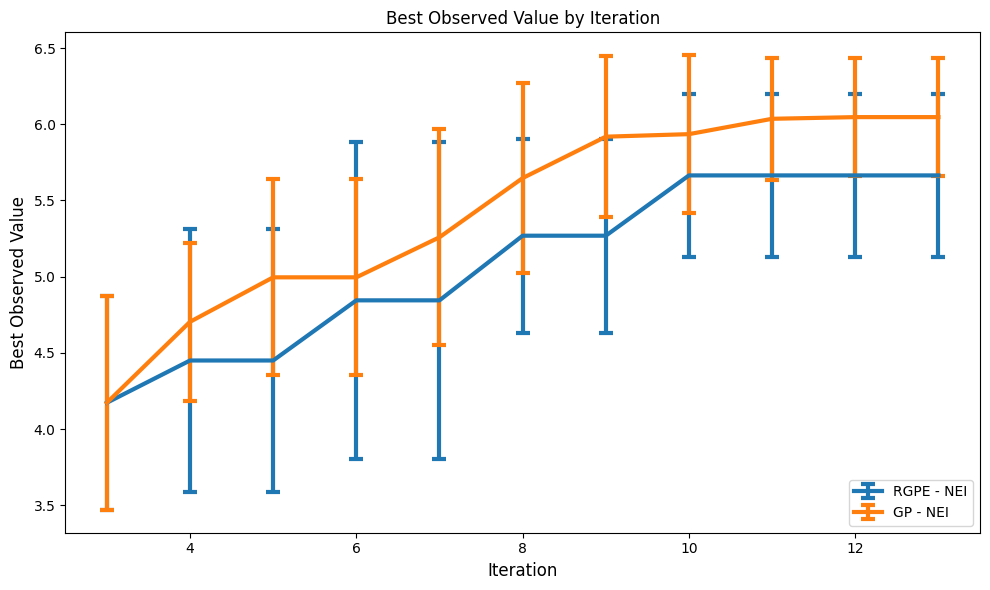

In [65]:
import numpy as np

best_rgpe_all = np.array(best_rgpe_all)
best_random_all = np.array(best_random_all)
best_vanilla_nei_all = np.array(best_vanilla_nei_all)

x = range(RANDOM_INITIALIZATION_SIZE, RANDOM_INITIALIZATION_SIZE + N_BATCH + 1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Plot RGPE - NEI
ax.errorbar(
    x,
    best_rgpe_all.mean(axis=0),
    yerr=1.96 * best_rgpe_all.std(axis=0) / math.sqrt(N_TRIALS),
    label="RGPE - NEI",
    linewidth=3,
    capsize=5,
    capthick=3,
)
# Plot FixedNoiseGP - NEI
ax.errorbar(
    x,
    best_vanilla_nei_all.mean(axis=0),
    yerr=1.96 * best_vanilla_nei_all.std(axis=0) / math.sqrt(N_TRIALS),
    label="GP - NEI",
    linewidth=3,
    capsize=5,
    capthick=3,
)

# # Plot Random
# ax.errorbar(
#     x,
#     best_random_all.mean(axis=0),
#     yerr=1.96 * best_random_all.std(axis=0) / math.sqrt(N_TRIALS),
#     label="Random",
#     linewidth=3,
#     capsize=5,
#     capthick=3,
# )

# ax.set_ylim(bottom=0)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Best Observed Value", fontsize=12)
ax.set_title("Best Observed Value by Iteration", fontsize=12)
ax.legend(loc="lower right", fontsize=10)
plt.tight_layout()

In [28]:
best_vanilla_nei_all

array([[4.26150866, 4.3928868 , 4.3928868 , 4.3928868 , 6.35429682,
        6.35429682, 6.35429682, 6.35429682, 6.35429682, 6.35429682,
        6.35429682],
       [4.02604207, 4.02604207, 6.39803946, 6.39803946, 6.39803946,
        6.39803946, 6.39803946, 6.39803946, 6.39803946, 6.39803946,
        6.39803946],
       [4.35537991, 4.35537991, 4.35537991, 4.35537991, 4.35537991,
        5.34565452, 5.34565452, 5.34565452, 5.34565452, 5.34565452,
        5.34565452],
       [5.17420353, 6.37360716, 6.37360716, 6.37360716, 6.37360716,
        6.37360716, 6.37360716, 6.37360716, 6.37360716, 6.37360716,
        6.37360716],
       [4.29276748, 4.29276748, 4.29276748, 5.84385026, 5.84385026,
        5.84385026, 6.51946448, 6.51946448, 6.51946448, 6.51946448,
        6.51946448],
       [5.29192443, 5.29192443, 5.29192443, 5.29192443, 5.29192443,
        6.50000943, 6.50000943, 6.50000943, 6.50000943, 6.50000943,
        6.50000943],
       [4.08301949, 4.08301949, 4.08301949, 4.08301949, 4.

In [35]:
best_rgpe_all

array([[4.26150866, 4.26150866, 4.26150866, 4.26150866, 4.28371566,
        4.28371566, 4.28371566, 4.28371566, 4.28371566, 4.28371566,
        4.28371566],
       [4.02604207, 4.02604207, 4.02604207, 4.02604207, 4.02604207,
        6.37850413, 6.37850413, 6.37850413, 6.37850413, 6.37850413,
        6.37850413],
       [4.35537991, 4.35537991, 6.42773026, 6.42773026, 6.42773026,
        6.42773026, 6.42773026, 6.42773026, 6.42773026, 6.42773026,
        6.42773026],
       [5.17420353, 5.17420353, 5.17420353, 5.17420353, 5.17420353,
        5.17420353, 5.17420353, 5.17420353, 5.17420353, 5.17420353,
        5.17420353],
       [4.29276748, 4.29276748, 6.33167852, 6.33167852, 6.33167852,
        6.33167852, 6.33167852, 6.33167852, 6.33167852, 6.33167852,
        6.33167852],
       [5.29192443, 5.29192443, 5.29192443, 5.29192443, 5.29192443,
        5.29192443, 5.29192443, 5.29192443, 5.29192443, 5.29192443,
        5.29192443],
       [4.08301949, 6.39417574, 6.39417574, 6.39417574, 6.

In [32]:
import numpy as np
from scipy.stats import ttest_rel

# Your array
data = np.array([[4.26150866, 4.3928868 , 4.3928868 , 4.3928868 , 6.35429682, 6.35429682, 6.35429682, 6.35429682, 6.35429682, 6.35429682, 6.35429682],
                 [4.02604207, 4.02604207, 6.39803946, 6.39803946, 6.39803946, 6.39803946, 6.39803946, 6.39803946, 6.39803946, 6.39803946, 6.39803946],
                 [4.35537991, 4.35537991, 4.35537991, 4.35537991, 4.35537991, 5.34565452, 5.34565452, 5.34565452, 5.34565452, 5.34565452, 5.34565452],
                 [5.17420353, 6.37360716, 6.37360716, 6.37360716, 6.37360716, 6.37360716, 6.37360716, 6.37360716, 6.37360716, 6.37360716, 6.37360716],
                 [4.29276748, 4.29276748, 4.29276748, 5.84385026, 5.84385026, 5.84385026, 6.51946448, 6.51946448, 6.51946448, 6.51946448, 6.51946448],
                 [5.29192443, 5.29192443, 5.29192443, 5.29192443, 5.29192443, 6.50000943, 6.50000943, 6.50000943, 6.50000943, 6.50000943, 6.50000943],
                 [4.08301949, 4.08301949, 4.08301949, 4.08301949, 4.08301949, 4.31113835, 6.46142368, 6.46142368, 6.46142368, 6.46142368, 6.46142368],
                 [1.77264942, 4.43970952, 4.43970952, 4.43970952, 4.43970952, 4.43970952, 4.43970952, 4.43970952, 5.31030387, 5.31030387, 5.31030387]])

# Extracting the first and second elements from each row
first_elements = data[:, 0]
second_elements = data[:, 1]

# Perform the paired t-test
t_statistic, p_value = ttest_rel(first_elements, second_elements)

t_statistic, p_value


(-1.4588391663119682, 0.18797381778282907)

In [55]:
first_elements = data[:, 0]
data[:, 0]

array([4.26150866, 4.02604207, 4.35537991, 5.17420353, 4.29276748,
       5.29192443, 4.08301949, 1.77264942])

In [56]:
second_elements = data[:, 1]
data[:, 1]

array([4.3928868 , 4.02604207, 4.35537991, 6.37360716, 4.29276748,
       5.29192443, 4.08301949, 4.43970952])

In [59]:
data.shape[1]

11

In [64]:
# One-tailed paired t-test between successive elements - vanilla GP or RGPE
import numpy as np
from scipy.stats import ttest_rel

data = best_vanilla_nei_all  
# data = best_rgpe_all

# Number of columns
n_cols = data.shape[1]

# Perform the one-tailed paired t-test for all successive elements
t_statistics = []
p_values = []

for i in range(n_cols - 1):
    t_stat, p_val = ttest_rel(data[:, i + 1], data[:, i]) # difference is A-B
    
    # Adjusting the p-value for a one-tailed test
    if t_stat > 0:
        p_val /= 2
    else:
        p_val = 1 - (p_val / 2)
    
    t_statistics.append(t_stat)
    p_values.append(p_val)

# Display the results
t_statistics, p_values

([1.458839164205042,
  1.0,
  1.0,
  1.0000000000000002,
  1.712759434197139,
  1.3083560498964442,
  nan,
  1.0000000000000002,
  nan,
  nan],
 [0.0939869091719254,
  0.17530833141010374,
  0.17530833141010374,
  0.1753083314101037,
  0.065242420517186,
  0.11603621964811575,
  nan,
  0.1753083314101037,
  nan,
  nan])

In [67]:
# One-tailed paired t-test between vanilla GP and RGPE
import numpy as np
from scipy.stats import ttest_rel

# Extracting the necessary pairs for one-tailed t-tests between each element
n_cols = best_vanilla_nei_all.shape[1]

t_statistics = []
one_tailed_p_values = []

for i in range(n_cols):
    vanilla_elements = best_vanilla_nei_all[:, i]
    RGPE_elements = best_rgpe_all[:, i]
    
    # Perform the one-tailed paired t-test
    t_stat, p_val = ttest_rel(RGPE_elements, vanilla_elements) # difference is A-B
    
    # Adjust the p-value for a one-tailed test
    if t_stat > 0:
        one_tailed_p_val = p_val / 2
    else:
        one_tailed_p_val = 1 - (p_val / 2)
    
    t_statistics.append(t_stat)
    one_tailed_p_values.append(one_tailed_p_val)

t_statistics, one_tailed_p_values

([nan,
  -0.4285391556287225,
  0.18340202636618425,
  0.29502019122554723,
  -0.13166484310565157,
  -0.10551553216532329,
  -1.1213199044413147,
  -1.1213199044413147,
  -1.5085186544318177,
  -1.5085186544318177,
  -1.5085186544318177],
 [nan,
  0.6594316413591007,
  0.4298409301677807,
  0.38826822846628706,
  0.5505230794424738,
  0.5405366357140979,
  0.8504301283704654,
  0.8504301283704654,
  0.9124204207081961,
  0.9124204207081961,
  0.9124204207081961])

In [68]:
# Two tailed paired t-test between successive elements of vanilla GP/RGPE
import numpy as np
from scipy.stats import ttest_rel

data = best_vanilla_nei_all  
# data = best_rgpe_all

# Number of columns
n_cols = data.shape[1]

# Perform the two-tailed paired t-test for all successive elements
t_statistics = []
p_values = []

for i in range(n_cols - 1):
    t_stat, p_val = ttest_rel(data[:, i + 1], data[:, i])
    
    # No adjustment needed for two-tailed test
    t_statistics.append(t_stat)
    p_values.append(p_val)

# Display the results
t_statistics, p_values


([1.458839164205042,
  1.0,
  1.0,
  1.0000000000000002,
  1.712759434197139,
  1.3083560498964442,
  nan,
  1.0000000000000002,
  nan,
  nan],
 [0.1879738183438508,
  0.3506166628202075,
  0.3506166628202075,
  0.3506166628202074,
  0.130484841034372,
  0.2320724392962315,
  nan,
  0.3506166628202074,
  nan,
  nan])

In [69]:
# Two-tailed paired t-test between vanilla GP and RGPE

import numpy as np
from scipy.stats import ttest_rel

# Extracting the necessary pairs for two-tailed t-tests between each element
n_cols = best_vanilla_nei_all.shape[1]

t_statistics = []
two_tailed_p_values = []

for i in range(n_cols):
    vanilla_elements = best_vanilla_nei_all[:, i]
    RGPE_elements = best_rgpe_all[:, i]
    
    # Perform the two-tailed paired t-test
    t_stat, p_val = ttest_rel(RGPE_elements, vanilla_elements)
    
    t_statistics.append(t_stat)
    two_tailed_p_values.append(p_val)

t_statistics, two_tailed_p_values

([nan,
  -0.4285391556287225,
  0.18340202636618425,
  0.29502019122554723,
  -0.13166484310565157,
  -0.10551553216532329,
  -1.1213199044413147,
  -1.1213199044413147,
  -1.5085186544318177,
  -1.5085186544318177,
  -1.5085186544318177],
 [nan,
  0.6811367172817986,
  0.8596818603355614,
  0.7765364569325741,
  0.8989538411150524,
  0.9189267285718041,
  0.29913974325906934,
  0.29913974325906934,
  0.17515915858360798,
  0.17515915858360798,
  0.17515915858360798])

## Plot weights versus iterations

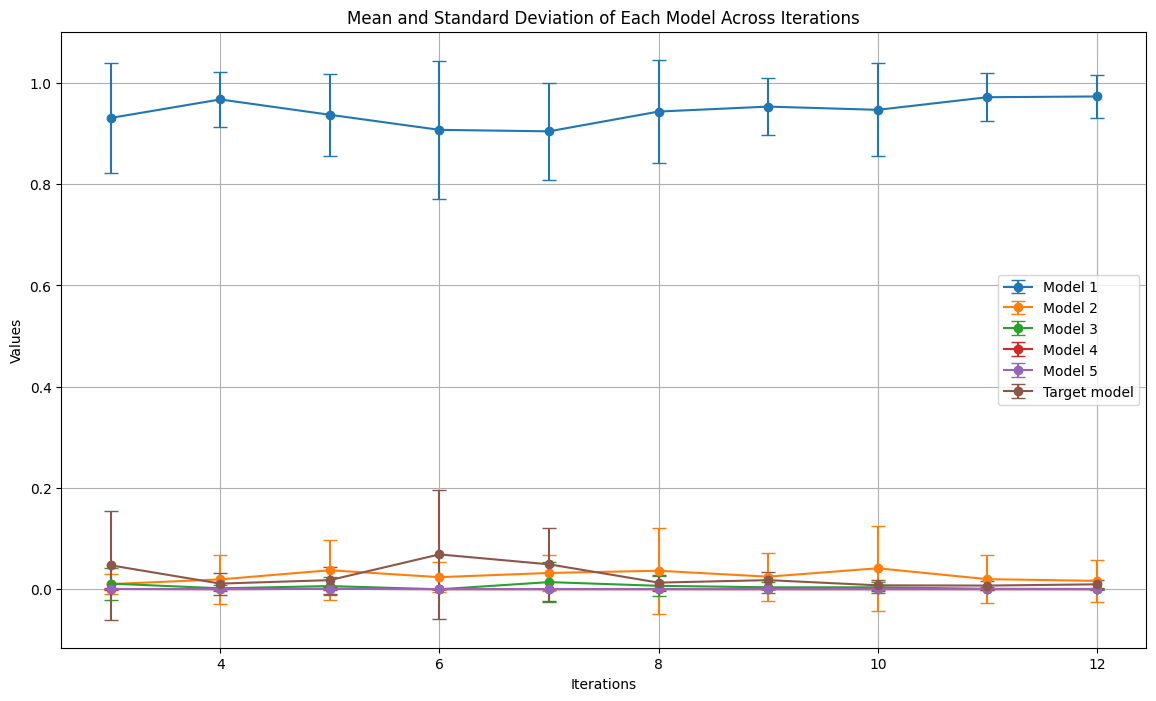

In [26]:
import torch
import matplotlib.pyplot as plt

# Given list of tensors

tensor_list=rank_weights_all

x = range(RANDOM_INITIALIZATION_SIZE, RANDOM_INITIALIZATION_SIZE + N_BATCH)

def extract_all_columns_mean_std(tensor_list):
    # Determine the number of columns
    num_columns = len(tensor_list[0][0])
    
    # Initialize lists to hold mean and std tensors for each column
    means = []
    stds = []
    
    for column_index in range(num_columns):
        # Extract the specified column from each tensor in each element of the tensor list
        columns = [torch.tensor([t[column_index] for t in element], dtype=torch.float64) for element in tensor_list]
        
        # Stack columns to create a 2D tensor
        stacked_columns = torch.stack(columns)
        
        # Calculate the mean element-wise
        mean_tensor = torch.mean(stacked_columns, dim=0)
        
        # Calculate the standard deviation element-wise
        std_tensor = torch.std(stacked_columns, dim=0)
        
        # Append to the lists
        means.append(mean_tensor)
        stds.append(std_tensor)
    
    return means, stds

# Calculate mean and standard deviation for all columns
means, stds = extract_all_columns_mean_std(tensor_list)

plt.figure(figsize=(14, 8))

for i, (mean_tensor, std_tensor) in enumerate(zip(means, stds)):
    label = f'Model {i+1}' if i < len(means) - 1 else 'Target model'
    plt.errorbar(x, mean_tensor.numpy(), yerr=std_tensor.numpy(), 
                 label=label, marker='o', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Values')
plt.title('Mean and Standard Deviation of Each Model Across Iterations')
plt.legend()
plt.grid(True)
plt.show()